In [168]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

import librosa

In [169]:
def onehot(str):
    path = './Drum'
    kits = os.listdir(path)
    #kits.remove('.DS_Store')
    
    oh = []

    for kit in kits:
        if str == kit:
            oh.append(1)
        else:
            oh.append(0)
    
    return np.array(oh)

In [170]:
def make4096(wav):
    while len(wav) < 4096:
        wav = np.append(wav, np.array([0]))
    return wav[:4096]
            

---

In [171]:
#path = 'Drum\Snare\9th Snare 38.wav'

y_label = None
x_label = None

drumkit_path = './Drum'
kits = os.listdir(drumkit_path)
n=0

for kit in kits:
    path = os.path.join(drumkit_path, kit)
    sounds = os.listdir(path)
    
    for sound in sounds:
        wavfile = os.path.join(path, sound)
        y, sr = librosa.load(wavfile)
        yt, index = librosa.effects.trim(y=y, top_db=30)
        y_16k = librosa.resample(yt, orig_sr=sr, target_sr=16000)
        #yt16k = librosa.util.normalize(y_16k)
        n += len(y_16k)
        yt16k = make4096(y_16k)
        yt16k = np.expand_dims(yt16k, axis=0)
        
        typ = onehot(kit)
        typ = np.expand_dims(typ, axis=0)
        
        if x_label is None:
            x_label = yt16k.copy()
            y_label = typ.copy()
        else:
            x_label = np.concatenate((x_label, yt16k), axis=0)
            y_label = np.concatenate((y_label, typ), axis=0)
        
        

In [175]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_label, y_label, test_size=0.2)

In [176]:
yy_test = np.argmax(y_test, axis = 1)
yy_train = np.argmax(y_train, axis = 1)

---

In [193]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4096), dtype=tf.float32,),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(7)
    ])

In [194]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, yy_train, epochs=20, validation_split=0.2)

Epoch 1/20
14/14 [==============================] - 0s 11ms/step - loss: 1.8918 - accuracy: 0.2589 - val_loss: 1.9418 - val_accuracy: 0.2946
Epoch 2/20
14/14 [==============================] - 0s 5ms/step - loss: 0.9168 - accuracy: 0.8371 - val_loss: 2.0044 - val_accuracy: 0.4107
Epoch 3/20
14/14 [==============================] - 0s 5ms/step - loss: 0.5956 - accuracy: 0.9643 - val_loss: 2.0647 - val_accuracy: 0.4643
Epoch 4/20
14/14 [==============================] - 0s 5ms/step - loss: 0.4098 - accuracy: 0.9710 - val_loss: 2.1114 - val_accuracy: 0.5000
Epoch 5/20
14/14 [==============================] - 0s 5ms/step - loss: 0.2832 - accuracy: 0.9888 - val_loss: 2.1794 - val_accuracy: 0.4732
Epoch 6/20
14/14 [==============================] - 0s 5ms/step - loss: 0.1968 - accuracy: 0.9933 - val_loss: 2.2828 - val_accuracy: 0.4375
Epoch 7/20
14/14 [==============================] - 0s 5ms/step - loss: 0.1370 - accuracy: 0.9933 - val_loss: 2.3016 - val_accuracy: 0.4464
Epoch 8/20
14/14 [=

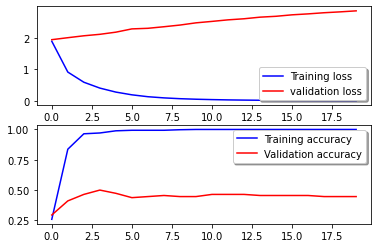

In [195]:
import matplotlib.pyplot as plt

# Plot the loss and accurac curves for training and validation

fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
ax[0].plot(history.history['val_loss'], color='r', label = "validation loss", axes = ax[0])
legend = ax[0].legend(loc='best', shadow = True)

ax[1].plot(history.history['accuracy'], color = 'b', label = "Training accuracy")
ax[1].plot(history.history['val_accuracy'], color = 'r', label = "Validation accuracy")
legend = ax[1].legend(loc = 'best', shadow = True)

In [198]:
y_pred =model.predict(x_test)
ypred = np.argmax(y_pred,axis=1)

<AxesSubplot:>

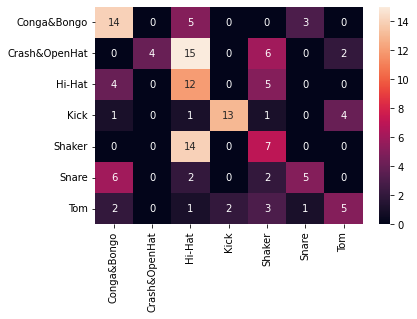

In [199]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

classes = ['Conga&Bongo', 'Crash&OpenHat', 'Hi-Hat', 'Kick', 'Shaker', 'Snare', 'Tom']

cm = pd.DataFrame(confusion_matrix(yy_test, ypred), columns=classes, index=classes)
sns.heatmap(cm, annot=True)

Making a better Model

In [185]:
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[4096]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(7, activation='softmax'))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [186]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

In [187]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\cid2r\AppData\Local\Temp/ipykernel_30464/1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [188]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
"n_hidden": [0, 1, 2, 3],
"n_neurons": np.arange(1, 100).tolist(),
"learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)

rnd_search_cv.fit(x_train, yy_train, epochs=1000, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/1000
10/10 [==============================] - 0s 18ms/step - loss: 1.9592 - accuracy: 0.1141 - val_loss: 1.9316 - val_accuracy: 0.1733
Epoch 2/1000
10/10 [==============================] - 0s 7ms/step - loss: 1.9452 - accuracy: 0.1611 - val_loss: 1.9313 - val_accuracy: 0.1733
Epoch 3/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.9309 - accuracy: 0.1745 - val_loss: 1.9331 - val_accuracy: 0.1200
Epoch 4/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.9234 - accuracy: 0.1879 - val_loss: 1.9304 - val_accuracy: 0.1733
Epoch 5/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.9144 - accuracy: 0.1879 - val_loss: 1.9239 - val_accuracy: 0.1600
Epoch 6/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.9072 - accuracy: 0.1879 - val_loss: 1.9227 - val_accuracy: 0.1733
Epoch 7/1000
10/10 [==============================] - 0s 6ms/step - loss: 1.8982 - acc

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000027BDCF39760>,
                   param_distributions={'learning_rate': [0.026130681826589758,
                                                          0.024381180526537243,
                                                          0.006570997185208696,
                                                          0.0004903609983262353,
                                                          0.00042613293847337596,
                                                          0.002020437013774331,
                                                          0.001430129023356253,
                                                          0.0003772922308550493,
                                                          0.0010963425699181376,
                                                          0.00085789405...
                                                          0.00596563107

In [189]:
rnd_search_cv.best_params_

{'n_neurons': 76, 'n_hidden': 3, 'learning_rate': 0.012245558033170328}

In [190]:
model = rnd_search_cv.best_estimator_.model

In [191]:
y_pred =model.predict(x_test)
ypred = np.argmax(y_pred,axis=1)

<AxesSubplot:>

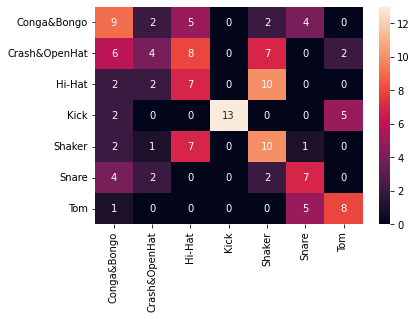

In [192]:
cm = pd.DataFrame(confusion_matrix(yy_test, ypred), columns=classes, index=classes)
sns.heatmap(cm, annot=True)